## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [20]:
# checkpoint_path = "backup\checkpoint_400.pt"
# model = load_model(hparams)
# model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
# _ = model.cuda().eval().half()

checkpoint_path = "backup\checkpoint_400.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval().half()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10932\88769790.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path)['sta

#### Load WaveGlow for mel2audio synthesis and denoiser

In [23]:
# waveglow_path = 'backup\waveglow_256channels_ljs_v2.pt'
# waveglow = torch.load(waveglow_path)['model']
# waveglow.cuda().eval().half()
# for k in waveglow.convinv:
#     k.float()
# denoiser = Denoiser(waveglow)


waveglow_path = 'backup\waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path, map_location='cpu')['model']
waveglow.eval().half()
for k in waveglow.convinv:
    k.float()
#denoiser = Denoiser(waveglow)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10932\1112887043.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  waveglow = torch.load(waveglow_path, map_location='

#### Prepare text input

In [25]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    #torch.from_numpy(sequence)).cuda().long()
    torch.from_numpy(sequence)).long()

#### Decode text input and plot results

Warning! Reached max decoder steps


ValueError: 'bottom' is not a valid value for origin; supported values are 'upper', 'lower'

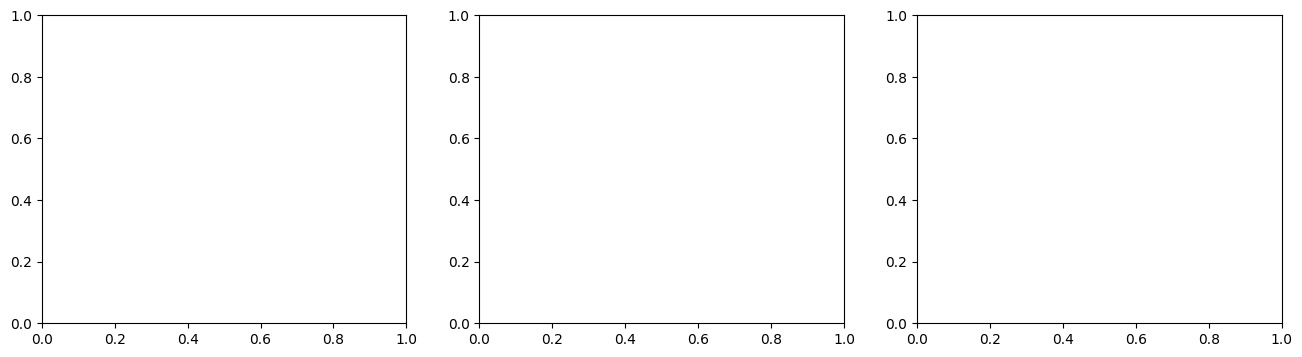

In [26]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [27]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

TypeError: type torch.cuda.FloatTensor not available. Torch not compiled with CUDA enabled.

#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

: 